## Obejctive: Using a Long Term Shrot Memory of Recurrent Neural Network to predict Amazon stock prices. 

## Content:


## Import Data and Set Up Environment

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch.nn as nn
import torch
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader

In [2]:
!wget https://raw.githubusercontent.com/tonylaioffer/stock-prediction-lstm-using-keras/master/data/sandp500/all_stocks_5yr.csv

--2022-09-22 20:44:25--  https://raw.githubusercontent.com/tonylaioffer/stock-prediction-lstm-using-keras/master/data/sandp500/all_stocks_5yr.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 29580549 (28M) [text/plain]
Saving to: ‘all_stocks_5yr.csv’

all_stocks_5yr.csv  100%[===================>]  28.21M  --.-KB/s    in 0.07s   

2022-09-22 20:44:30 (423 MB/s) - ‘all_stocks_5yr.csv’ saved [29580549/29580549]



In [3]:
dataset = data = pd.read_csv('./all_stocks_5yr.csv')
dataset_cl = dataset[dataset['Name']=='AMZN'].close.values


## Feature Normalization

In [4]:
from sklearn.preprocessing import MinMaxScaler

sc = MinMaxScaler(feature_range = (0, 1))
dataset_cl = dataset_cl.reshape(dataset_cl.shape[0], 1)
dataset_cl = sc.fit_transform(dataset_cl)

## Cutting Time Series into Sequences

In [5]:
def processData(data, lb):
    X, Y = [], []
    for i in range(len(data) - lb - 1):
        X.append(data[i: (i + lb), 0])
        Y.append(data[(i + lb), 0])
    return np.array(X), np.array(Y)
X, y = processData(dataset_cl, 7)

In [6]:
X[:5], y [:5]

(array([[0.01140805, 0.00746678, 0.0087057 , 0.01766085, 0.01746961,
         0.01401892, 0.01789367],
        [0.00746678, 0.0087057 , 0.01766085, 0.01746961, 0.01401892,
         0.01789367, 0.01511649],
        [0.0087057 , 0.01766085, 0.01746961, 0.01401892, 0.01789367,
         0.01511649, 0.01472569],
        [0.01766085, 0.01746961, 0.01401892, 0.01789367, 0.01511649,
         0.01472569, 0.01429332],
        [0.01746961, 0.01401892, 0.01789367, 0.01511649, 0.01472569,
         0.01429332, 0.00967855]]),
 array([0.01511649, 0.01472569, 0.01429332, 0.00967855, 0.00925449]))

## Training and Test Data Split

In [7]:
X_train, X_test = X[:int(X.shape[0]*0.80)],X[int(X.shape[0]*0.80):]
y_train, y_test = y[:int(y.shape[0]*0.80)],y[int(y.shape[0]*0.80):]
print(X_train.shape[0])
print(X_test.shape[0])
print(y_train.shape[0])
print(y_test.shape[0])
# reshaping
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

1000
251
1000
251


## Build an RNN Regression Model  

In [8]:
class RNN(nn.Module):
    def __init__(self, i_size, h_size, n_layers, o_size, dropout=0.1, bidirectional=True):
        super(RNN, self).__init__()
        self.num_directions = bidirectional+1
        self.rnn = nn.LSTM(
            input_size=i_size,
            hidden_size=h_size,
            num_layers=n_layers,
            dropout=dropout,
            bidirectional=bidirectional
        )
        self.out = nn.Linear(h_size, o_size)

    def forward(self, x, h_state):
        r_out, hidden_state = self.rnn(x, h_state)
        
        hidden_size = hidden_state[-1].size(-1)
        r_out = r_out.view(-1, self.num_directions, hidden_size)
        outs = self.out(r_out)
        
        return outs, hidden_state

In [9]:
INPUT_SIZE = 7
HIDDEN_SIZE = 64
NUM_LAYERS = 3
OUTPUT_SIZE = 1
BATCH_SIZE = 128
# Hyper parameters

learning_rate = 0.001
num_epochs = 300

rnn = RNN(INPUT_SIZE, HIDDEN_SIZE, NUM_LAYERS, OUTPUT_SIZE,bidirectional=False)
rnn.cuda()

optimiser = torch.optim.Adam(rnn.parameters(), lr=learning_rate)
criterion = nn.MSELoss()

hidden_state = None
rnn

RNN(
  (rnn): LSTM(7, 64, num_layers=3, dropout=0.1)
  (out): Linear(in_features=64, out_features=1, bias=True)
)

In [ ]:
history = []
X_test_cuda = torch.tensor(X_test).float().cuda()
y_test_cuda = torch.tensor(y_test).float().cuda()

# we use all the data in one batch
inputs_cuda = torch.tensor(X_train).float().cuda()
labels_cuda = torch.tensor(y_train).float().cuda()

for epoch in range(num_epochs):
    rnn.train()
    output, _ = rnn(inputs_cuda, hidden_state) 
    # print(output.size())

    loss = criterion(output[:,0,:].view(-1), labels_cuda)
    optimiser.zero_grad()
    loss.backward()                     # back propagation
    optimiser.step()                    # update the parameters
    
    if epoch % 20 == 0:
        rnn.eval()
        test_output, _ = rnn(X_test_cuda, hidden_state)
        test_loss = criterion(test_output.view(-1), y_test_cuda)
        print('epoch {}, loss {}, eval loss {}'.format(epoch, loss.item(), test_loss.item()))
    else:
        print('epoch {}, loss {}'.format(epoch, loss.item()))
    history.append(loss.item())

## Checking Model Performance

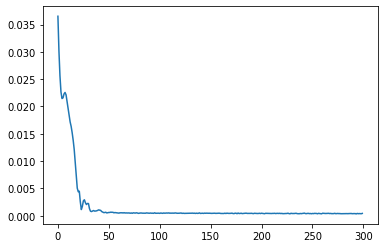

In [11]:
rnn.eval()
test_predict, _ = rnn(X_test_cuda, hidden_state)
test_predict_cpu = test_predict.cpu().detach().numpy()
plt.plot(history)

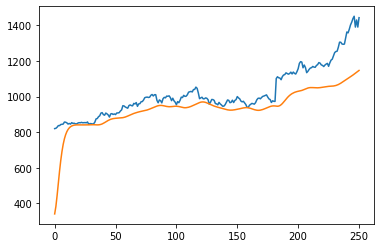

In [12]:
plt.plot(sc.inverse_transform(y_test.reshape(-1,1)))
plt.plot(sc.inverse_transform(test_predict_cpu.reshape(-1,1)))

In [28]:
predictions = sc.inverse_transform(y_test.reshape(-1,1))
test_data = sc.inverse_transform(test_predict_cpu.reshape(-1,1))
mse = np.sum(predictions - test_data)/len(predictions)
rmse = np.sqrt(mse)
rmse

8.603126654637194

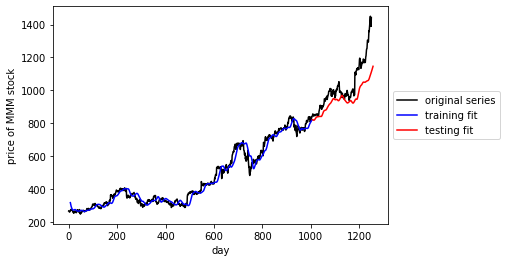

In [13]:
# plot original data
plt.plot(sc.inverse_transform(y.reshape(-1,1)), color='k')

# train_inputs = torch.tensor(X_train).float().cuda()
train_pred, hidden_state = rnn(inputs_cuda, None)
train_pred_cpu = train_pred.cpu().detach().numpy()

# use hidden state from previous training data
test_predict, _ = rnn(X_test_cuda, hidden_state)
test_predict_cpu = test_predict.cpu().detach().numpy()

# plt.plot(scl.inverse_transform(y_test.reshape(-1,1)))
split_pt = int(X.shape[0] * 0.80) + 7 # window_size
plt.plot(np.arange(7, split_pt, 1), sc.inverse_transform(train_pred_cpu.reshape(-1,1)), color='b')
plt.plot(np.arange(split_pt, split_pt + len(test_predict_cpu), 1), sc.inverse_transform(test_predict_cpu.reshape(-1,1)), color='r')

# pretty up graph
plt.xlabel('day')
plt.ylabel('price of MMM stock')
plt.legend(['original series','training fit','testing fit'], loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()


## Conclusions
* Stock price can be accurately predicted in short time 
* However, this does not include other features that influence the stock price. It is not reasonalble to purely rely on this model